# Bradley-Terry
## Purpose
I created this notebook to gain a better understanding of the [Bradley-Terry Model](https://en.wikipedia.org/wiki/Bradley%E2%80%93Terry_model), which has been [used to allocate scores](https://www.kaggle.com/c/commonlitreadabilityprize/discussion/240423) for the [Common Lit Readability Prize](https://www.kaggle.com/c/commonlitreadabilityprize).
In particular I want to know:
1. Can we reconstruct the target scores from the results of "contests" between documents?
1. Is the reconstruction consistent? How much does it depend on the way the contestants have been sampled to build contests?
1. Is the reconstruction efficient? Can we do better with something like Expecation Maximization?

## Bradley-Terry

[1] and [4] give two forms of the equation.
$$\begin{align}P(\text{i beats j}) =& \frac{e^{\beta_i}}{e^{\beta_i}+e^{\beta_j}}\\
logit(P(\text{i beats j})) =& \lambda_i - \lambda_j \text{, where }\\
\lambda_i =& e^{\beta_i} \text{ and }\\
logit(p) =& \log\big(\frac{p}{1-p}\big)\end{align}$$

|Question|Outcome|
|---------------------------------------|-----------------------------------------------------------|
|Since some of the target scores in the context are negative, I conjecture that they correspond to the $\beta_i$||
|Target scores in contest are approximately Gaussian.What does this say about probabilities of contests?||

## Methods

This code contained in this notebook sets up contests between pairs of texts in the training dataset. The opponents for each text are selected at random, and the outcome of each context are chosen at random, with the probability of extract $i$ being deemed easier to read than extract $j$ given by $\frac{e^{\beta_i}}{e^{\beta_i}+e^{\beta_j}}$. 
## Results

I executed the code from this notebook offline, on my own laptop ($2\times 2.2 GHz$, 8 G RAM)
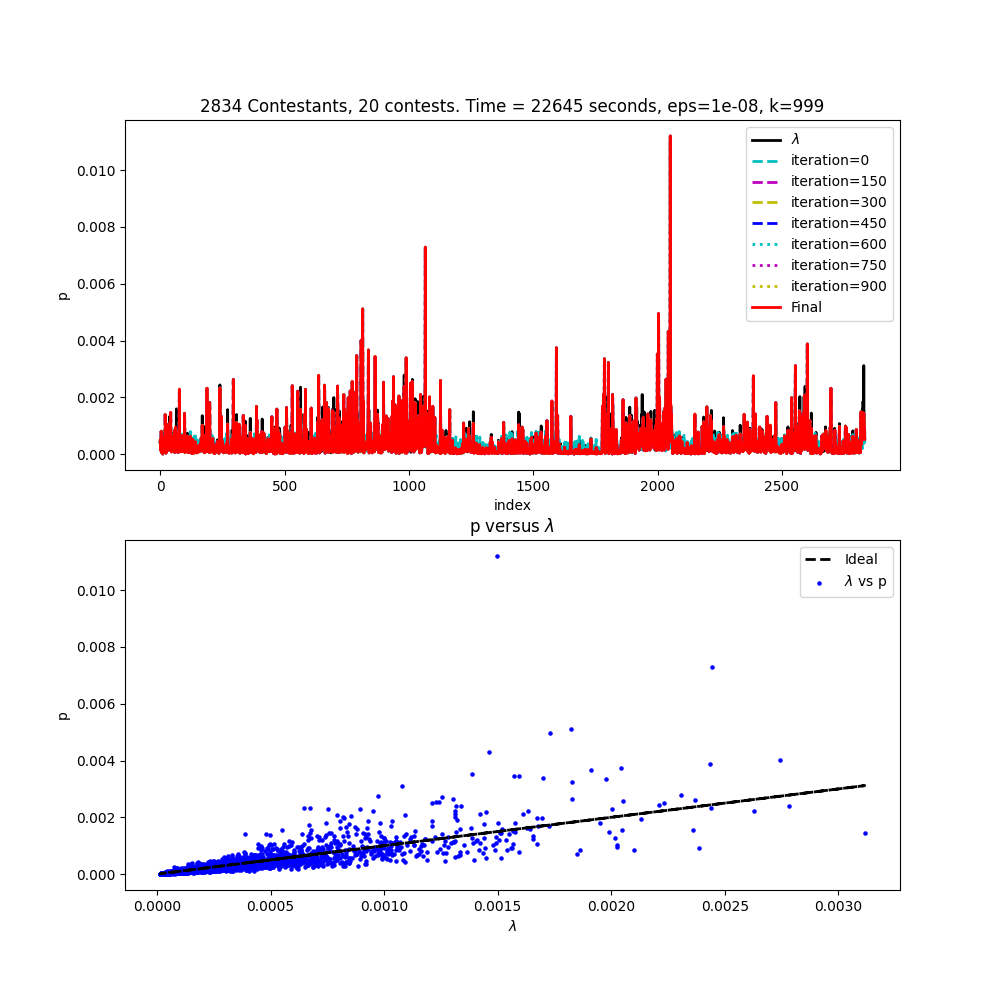. The execution time was in excess of 6 hours.

I performed two more runs on a subset of the dataset to test consistency.
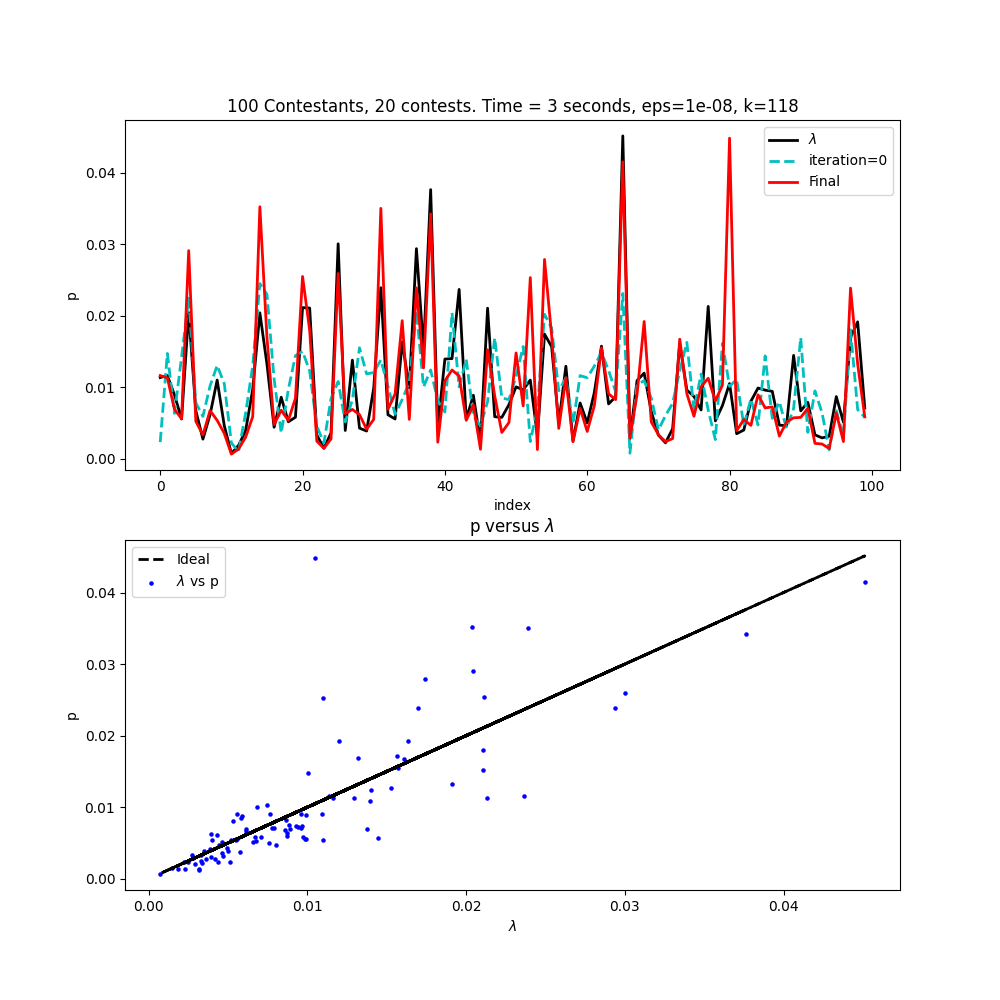
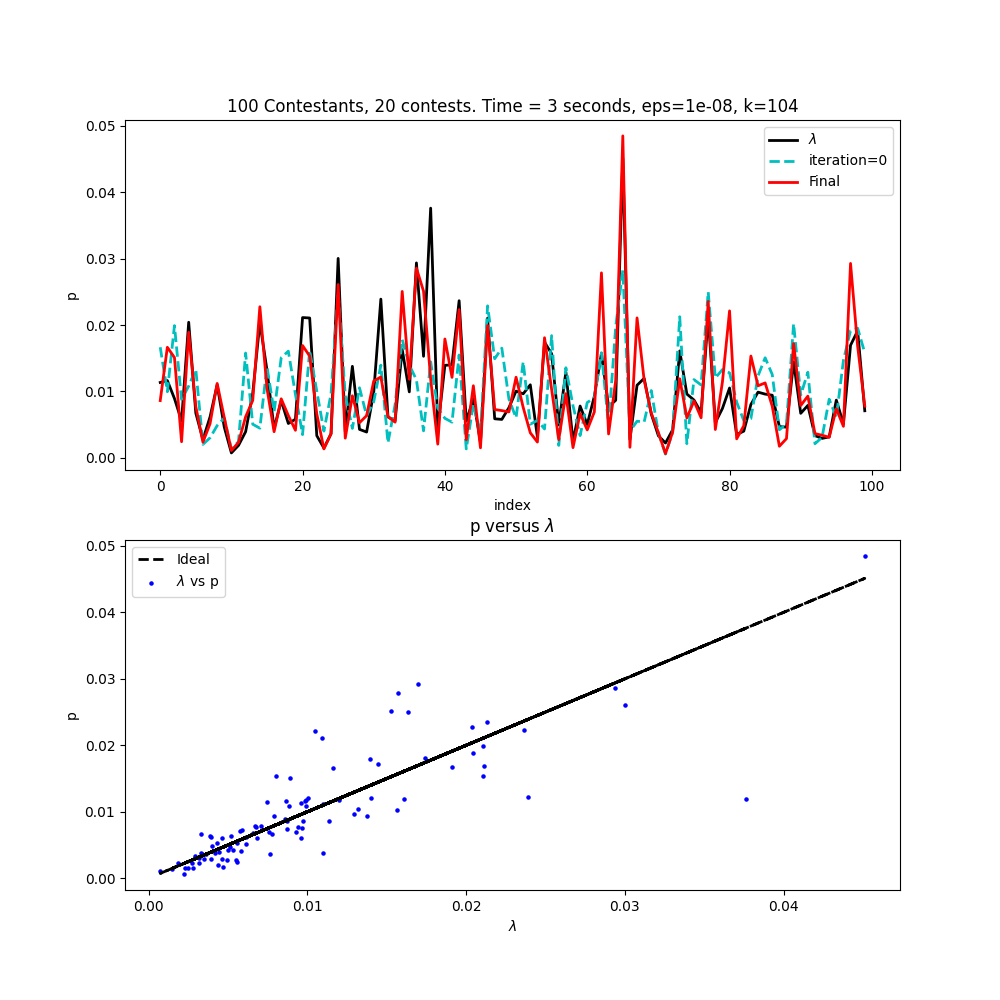

## Conclusions

1. Computing Bradley Terry was slow, using the Maximum Likelihood algorithm of [1].
1. The scatter plots show that the scores are broadly consistent with the original scores (highly ranked texts are likely to remain high), but there is considerable variability.
1. On balance, I no longer consider that the approach described in [Some thoughts on exploiting Bradley-Terry](https://www.kaggle.com/c/commonlitreadabilityprize/discussion/242023) to be viable.

## Further Work

1. Can we reduce execution time significantly using a more efficient algoritm, such as Expectation Maximization?[6]
1. Include RMS error in the scatter plots, as this would provide a lower bound on the competition score. *I have calculatesd RMS (not shown) for 500 texts, and got a value of 0.4, which is clearly too high.*

## References
||Title|Author|
|---|-----------------------------------------------|-----------------------------|
|[1]|[Bradley-Terry Model](https://en.wikipedia.org/wiki/Bradley%E2%80%93Terry_model)|Wikipedia Editors|
|[2]|[Log5, the Logit Link and Bradley-Terry](https://www.kaggle.com/jaredcross/log5-logistic-regression-and-bradley-te/comments)|Jared Cross|
|[3]|[Target scores](https://www.kaggle.com/c/commonlitreadabilityprize/discussion/240423)|Scott Crossley|
|[4]|[Bradley-Terry Models in R](https://www.jstatsoft.org/article/view/v012i01/v12i01.pdf)|David Firth|
|[5]|[Common Lit Readability Prize](https://www.kaggle.com/c/commonlitreadabilityprize)|Scott Crossley|
|[6]|[Efficient Bayesian Inference for Generalized Bradley-Terry Models](https://arxiv.org/abs/1011.1761)|Francois Caron and Arnaud Doucet|


In [ ]:
from cycler            import cycler
from matplotlib.pyplot import figure,bar,xlabel,ylabel,legend,rc, plot,savefig, title, scatter
from numpy             import argsort, exp, zeros, int32, sum
from numpy.random      import rand
from os                import walk
from os.path           import join
from pandas            import read_csv
from random            import random, randrange, gauss
from time              import time


rc('lines', linewidth=2)
rc('axes', 
   prop_cycle=(cycler(color=['c', 'm', 'y','b','c', 'm', 'y','b']) +
                  cycler(linestyle=[ '--', '--','--','--',':', ':', ':',':'])))


# Hyper parameters

In [ ]:
N_CONTESTS     = 20     # Minnimum number of contests for each contestant
N_MAX          = 100    # Limit number of contestants - set to None for no limi
MAX_ITERATIONS = 1000   # Used to limit iteations while computing BT
FREQUENCY      = 150    # For work in progress plots
PLOT_FILE      = 'bt-iterations'
EPSILON        = 1e-8   # Contols iterations

# Load Data

## Data Dictionary

|Train|Public Test|Hidden Test|Description|
|--------------|--------------|----------|----------------------------------------------------|
|id|id|id|Unique ID for excerpt|
|url_legal|url_legal|- |URL of source (Omitted from some records in the test set--see [note](https://www.kaggle.com/c/commonlitreadabilityprize/discussion/238670#1306025))|
|license|license |-|License of source material (Omitted from some records in the test set--see [note](https://www.kaggle.com/c/commonlitreadabilityprize/discussion/238670#1306025))|
|excerpt|excerpt|excerpt|Text for predicting readability|
|target|-|-|Readability|
|standard_error|-|-|Measure of spread of scores among multiple raters for each excerpt|

In [ ]:
train_data    = None

for dirname, _, filenames in walk('/kaggle/input'):
    for filename in filenames:
        path_name = join(dirname, filename)
        if filename.startswith('train'):
            train_data = read_csv(path_name)
                       

# Estimate Parameters

This is the algorithm from [Wikipedia](https://en.wikipedia.org/wiki/Bradley%E2%80%93Terry_model#Estimating_the_parameters). We will plot progress to convergence, and
compare result with initial values.


In [ ]:
# create_wins_losses
# # Compute a matrix w[i,k] -- the number of wins for i competing with k
def create_wins_losses(Lambdas):
    w  = zeros((N_MAX,N_MAX))
    for i in range(N_MAX):
        for j in range(N_CONTESTS):
            k = (i+randrange(1,N_MAX)) % N_MAX
            if random() < Lambdas[i]/(Lambdas[i] + Lambdas[k]):
                w[i,k] += 1
            else:
                w[k,i] += 1
    return w

# update
#
# Update probablities

def update(p,w_symmetric,W,N):
    p1 = zeros(N)
    for i in range(N):
        Divisor = 0
        for j in range(N):
            if i!=j and p[i]+p[j]>0:
                Divisor += w_symmetric[i,j]/(p[i]+p[j])
        p1[i] = W[i]/Divisor
    return p1/sum(p1)

# normalize
#
# Make elements of a vector sum to 1 so it can be used as a probability

def normalize(p):
    return p / sum(p)

start          = time()         
Betas          = train_data.target.to_numpy()
Lambdas        = exp(Betas)
N,_            = train_data.shape
if N_MAX==None:
    N_MAX = N
else:
    Lambdas    = Lambdas[:N_MAX]
w              = create_wins_losses( Lambdas)
w_symmetric    = w + w.transpose()
W              = sum(w,axis=1)  # Number won by i
p              = normalize(rand(N_MAX))

fig            = figure(figsize=(10,10))
axes           = fig.subplots(nrows=2,ncols=1)
axes[0].plot(range(N_MAX),Lambdas/sum(Lambdas),
             label     = r'$\lambda$',
             linestyle = '-',
             color     = 'k')

for k in range(MAX_ITERATIONS):
    p1 = update(p,w_symmetric,W,N_MAX)
    if (abs(p-p1)<EPSILON*p1).all():
        p = p1
        break
    p  = p1
    if k%FREQUENCY==0:
        axes[0].plot(range(N_MAX),p,
             label = f'iteration={k}')
        
axes[0].plot(range(N_MAX),p,
    label     = f'Final',
    linestyle = '-',
    color     = 'r')
axes[0].legend()
axes[0].set_xlabel('index')
axes[0].set_ylabel('p')
elapsed = int(time() - start)
axes[0].set_title(f'{N_MAX} Contestants, {N_CONTESTS} contests. Time = {elapsed} seconds, eps={EPSILON}, k={k}')

axes[1].scatter(Lambdas/sum(Lambdas),p,s=5,label=r'$\lambda$ vs p',color='b')
axes[1].plot(Lambdas/sum(Lambdas),Lambdas/sum(Lambdas),label='Ideal',color='k')
axes[1].set_xlabel(r'$\lambda$')
axes[1].set_ylabel('p')
axes[1].legend()
axes[1].set_title(r'p versus $\lambda$')
fig.savefig(PLOT_FILE,bbox_inches='tight')

